In [2]:
#Imports for Puyo environment
import gym
from gym import spaces
import pygame
import numpy as np
import math
import setuptools

#Imports for AI, using the homework as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import copy


C:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#The Puyo environment, made using the example on the gym documentation as reference
class PuyoEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    
    def __init__(self, render_mode=None):
        #game logic stuff
        self.num_colors = 4 #number of unique colors
        self.current_piece = self.get_new_piece()
        self.board = np.zeros((5, 12)) #12x5 grid, board[x][y] coordinates starting from top-right
        self.score = 0
        self.update_board()
        self.score_calc_table = {"chain power": [0, 0, 8, 16, 32, 64, 128, 256, 512, 999],
                                "color bonus": [0, 0, 3, 6, 12],
                                "group bonus": [0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 7, 10]}
        self.time = 1
        self.stall_penalty = -20000
        self.loss_penalty = -10000
        self.legal_reward = 5
        self.recent_actions = []
        
        #environment stuff
        #NOTE: THIS ISN'T ACCURATE ANYMORE
        self.observation_space = (np.full((5, 12), spaces.Box(0, self.num_colors, shape=(1,), dtype=int), dtype=spaces.Box), 
                                 {"coordinates": tuple(np.full((2,2), spaces.Box(0, 11, shape=(1,), dtype=int))),
                                 "colors": [spaces.Box(1, self.num_colors+1, shape=(1,)), spaces.Box(1, self.num_colors+1, shape=(1,))]})
        self.action_space = spaces.Discrete(4) #left, right, rotate, down
        
        #pygame stuff
        self.window_size = 512 #pygame window size
        self.render_mode = render_mode
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.window = None #Window used for human rendering
        self.clock = None #clcok to ensure envrionment is rendered at correct frame rate in human rendering mode
    
    def _get_obs(self):
        #obs is a 1D array consisting of the board, followed by current_piece coordinates and current_piece colors
        obs = self.board.flatten()
        #print(len(obs))
        #for column in self.board:
        #    for space in column:
        #        obs.append(space)
        #obs.append(self.current_piece["coordinates"][0])
        #obs.append(self.current_piece["coordinates"][1])
        #obs.append(self.current_piece["colors"][0])
        #obs.append(self.current_piece["colors"][1])
        obs = np.append(obs, self.current_piece["coordinates"][0])
        #obs = np.append(obs, self.current_piece["coordinates"][0][1])
        #print(len(obs))
        obs = np.append(obs, self.current_piece["coordinates"][1])
        #obs = np.append(obs, self.current_piece["coordinates"][1][1])
        #print(len(obs))
        obs = np.append(obs, self.current_piece["colors"][0])
        #print(len(obs))
        obs = np.append(obs, self.current_piece["colors"][1])
        #print(len(obs))
        return obs
        #return (self.board, self.current_piece) #Returns (board, {piece coordinates, piece colors})
    
    def _get_info(self): #Currently not needed, so just returns an empty dictionary
        return {}
    
    #Returns a new current_piece
    def get_new_piece(self):
        self.recent_actions = []
        return {"coordinates": ([2, 0], [2, 1]), 
                "colors": [np.random.randint(1, self.num_colors+1), np.random.randint(1, self.num_colors+1)]}
    
    #Updates the location of the current_piece onto the board
    def update_board(self):
        self.board[self.current_piece["coordinates"][0][0]][self.current_piece["coordinates"][0][1]] = self.current_piece["colors"][0]
        self.board[self.current_piece["coordinates"][1][0]][self.current_piece["coordinates"][1][1]] = self.current_piece["colors"][1]
        
    def reset(self, seed=None, options=None):
        #super().reset(seed=seed)
        #NOTE: I'M NOT USING THE ENVIRONMENT RNG BECAUSE I CAN'T FIND THE DOCUMENTATION, SO I MIGHT HAVE TO DO SEED SHENANIGANS
        self.current_piece = self.get_new_piece()
        self.board = np.zeros((5, 12))
        self.update_board()
        self.score = 0
        self.recent_actions = []
        
        observation = self._get_obs()
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()
            
        return observation, info
    
    #TODO: FINISH THIS
    def step(self, action):
        #Actions are 0, 1, 2, 3 for left, right, rotate, drop, respectively
        reward = 0 #0 by default, matching puyos in case 3 will change it
        terminated = False #false by default, if dropping leads to a fail, will change
        fail_check = False
        #Take action
        self.recent_actions.append(action) #Needed for checking for anti-stalling penalty
        if action == 0: #move left
            reward = self.move_left()
        elif action == 1: #move right
            reward = self.move_right()
        elif action == 2: #rotate piece
            reward = self.rotate_piece()
        elif action == 3: #drop piece
            reward = self.gravity()
            fail_check = True
        else:
            raise ValueError("Invalid action taken!  Input should be between 0-3")

        #Calculate reward
        #return all necessary information
        observation = self._get_obs()
        info = self._get_info()
        
        #Do autofall
        self.time += 1
        if self.time % 4 == 0 and fail_check == False:
            self.time = 1
            #make piece fall if it can (REMEMBER TO CONSIDER OUT OF BOUNDS STUFF)
            piece1 = self.current_piece["coordinates"][0]
            piece2 = self.current_piece["coordinates"][1]
            if piece1[0] != piece2[0]: #piece is positioned horizontally
                if piece1[1] == 11: #bottom of board, lock in place
                    fail_check = True
                    reward = self.gravity()
                else: #piece is above position 11, check to see if it can fall a space
                    if self.board[piece1[0]][piece1[1]+1] == 0 and self.board[piece2[0]][piece2[1]+1] == 0: #piece can fall
                        self.board[piece1[0]][piece1[1]] = 0
                        self.board[piece2[0]][piece2[1]] = 0
                        self.current_piece["coordinates"][0][1] += 1
                        self.current_piece["coordinates"][1][1] += 1
                        self.update_board()
                    else: #piece can't fall
                        fail_check = True
                        reward = self.gravity()
            else: #piece is positioned vertically
                lowest_piece = 0 if piece1[1] > piece2[1] else 1
                if self.current_piece["coordinates"][lowest_piece][1] == 11: #Bottom of board, lock in place
                    fail_check = True
                    reward = self.gravity()
                else: #Piece above position 11, check to see if it can fall a space
                    #print(f"lowest piece is #{lowest_piece}")
                    if self.board[self.current_piece["coordinates"][lowest_piece][0]][self.current_piece["coordinates"][lowest_piece][1]+1] == 0: #piece can fall a space
                        #print("Going down 1")
                        other_piece = 0 if lowest_piece == 1 else 1
                        self.board[piece1[0]][piece1[1]] = 0
                        self.board[piece2[0]][piece2[1]] = 0
                        self.current_piece["coordinates"][lowest_piece][1] += 1
                        self.current_piece["coordinates"][other_piece][1] += 1
                        self.update_board()
                    else: #piece can't fall 
                        #print("piece can't fall!")
                        fail_check = True
                        reward = self.gravity()
        
        #Check for fail only after setting a piece, ie through gravity or autofall clicked a piece into place
        #Autofall will mess with this
        if fail_check == True:
            if self.board[2][1] != 0:
                terminated = True
                reward = self.loss_penalty
            self.current_piece = self.get_new_piece()
            self.update_board()

        if self.render_mode == "human":
            self.render_frame()
        
        if reward == 0: #Legal move done, no matching took place
            reward = self.legal_reward 
        
        #NOTE: THIS PART MAY WANT TO BE COMMENTED OUT ONCE THE AI IS WORKING
        #self.score += reward
        return observation, reward, terminated, False, info
    
    #Tries to move the current piece to the left
    def move_left(self):
        #Check for stalling
        reward = 0
        if 1 in self.recent_actions:
            reward += self.stall_penalty
        #Move left
        piece_coords = self.current_piece["coordinates"]
        #If horizontal, check for collision against the farthest to the left (greatest x value)
        if piece_coords[0][1] == piece_coords[1][1]:
            x_to_check = max(piece_coords[0][0], piece_coords[1][0])
            if x_to_check < 4 and self.board[x_to_check+1][piece_coords[0][1]] == 0:
                self.move_left_helper(piece_coords)
            else:
                reward += self.stall_penalty
        #Not horizontal, need to check both x coordinates
        elif piece_coords[0][0] < 4 and piece_coords[1][0] < 4 and self.board[piece_coords[0][0]+1][piece_coords[0][1]] == 0 and self.board[piece_coords[1][0]+1][piece_coords[1][1]] == 0:
            self.move_left_helper(piece_coords)
        else:
            reward += self.stall_penalty
        return reward
    
    def move_left_helper(self, piece_coords):
            #Remove the current_piece off the board
            self.board[piece_coords[0][0]][piece_coords[0][1]] = 0
            self.board[piece_coords[1][0]][piece_coords[1][1]] = 0
            #Update coordinates of current piece
            self.current_piece["coordinates"][0][0] += 1
            self.current_piece["coordinates"][1][0] += 1
            #update the board
            self.update_board()                               
    
    def move_right(self):
        #Check fo rstalling
        reward = 0
        if 0 in self.recent_actions:
            reward += self.stall_penalty
        #Move right
        piece_coords = self.current_piece["coordinates"]
        #If horizontal, check for collision against farthest to the right (smallest x value)
        if piece_coords[0][1] == piece_coords[1][1]:
            x_to_check = min(piece_coords[0][0], piece_coords[1][0])
            if x_to_check > 0 and self.board[x_to_check-1][piece_coords[0][1]] == 0:
                self.move_right_helper(piece_coords)
            else:
                reward += self.stall_penalty
        #Not horizontal, need to check both x coordinates
        elif piece_coords[0][0] > 0 and piece_coords[1][0] > 0 and self.board[piece_coords[0][0]-1][piece_coords[0][1]] == 0 and self.board[piece_coords[1][0]-1][piece_coords[1][1]] == 0:
            self.move_right_helper(piece_coords)
        else:
            reward += self.stall_penalty
        return reward
            
    def move_right_helper(self, piece_coords):
        #Remove the current_piece off the board
        self.board[piece_coords[0][0]][piece_coords[0][1]] = 0
        self.board[piece_coords[1][0]][piece_coords[1][1]] = 0
        #Update coordinates of current piece
        self.current_piece["coordinates"][0][0] -= 1
        self.current_piece["coordinates"][1][0] -= 1
        #update the board
        self.update_board()
    
    def rotate_piece(self):
        #Check for stalling
        reward = 0
        if self.recent_actions.count(2) >= 4:
            reward += self.stall_penalty
        #The first piece always rotates counter-clockwise around the second piece, so only the first piece will move
        #Calculate new piece position
        angle = math.radians(90)
        piece1 = self.current_piece["coordinates"][0]
        piece2 = self.current_piece["coordinates"][1]
        new_piece1x = round(math.cos(angle) * (piece1[0] - piece2[0]) - math.sin(angle) * (piece1[1] - piece2[1]) + piece2[0])
        new_piece1y = round(math.sin(angle) * (piece1[0] - piece2[0]) + math.cos(angle) * (piece1[1] - piece2[1]) + piece2[1])
        #Check if inbounds and not colliding
        if new_piece1x >= 0 and new_piece1x <= 4 and new_piece1y >= 0 and new_piece1y <= 11 and self.board[new_piece1x][new_piece1y] == 0:
            #Erase current_piece1 off board (since piece 2 doesn't move)
            self.board[piece1[0]][piece1[1]] = 0
            #Set piece position to new position
            self.current_piece["coordinates"][0][0] = new_piece1x
            self.current_piece["coordinates"][0][1] = new_piece1y
            #Update the board
            self.update_board()
        else:
            reward += self.stall_penalty
        return reward
            
    #TODO: FINISH THIS HERE
    def gravity(self):
        terminated = False
        reward = 0
        repeat_gravity = True
        chain_info = {"chain length": 0,
                     "unique colors": [],
                     "puyos cleared": 0}

        while repeat_gravity:
            repeat_gravity = False
            #Make stuff fall down (and erase it from it was already was), MAKE SURE TO START AT BOTTOM FOR EACH COLUMN
            for column in self.board:
                self.puyo_fall(column)
            #Check for matched puyos
            #If puyos match, calculate reward gain and repeat_gravity
            repeat_gravity, reward_gain = self.match_puyos(chain_info)
            reward += reward_gain
        #Add reward to cumulative score
        self.score += reward
        #Loss condition checked in a different function because I have to change stuff so this code is getting cursed
        #Get a new piece has been moved to step with fail_check
        return reward
    
    #Given a 1D array x, make all puyos fall to the bottom
    def puyo_fall(self, x):
        swap = []
        for i in range(len(x)-1, -1, -1):
            if(x[i] == 0):
                swap.append(i)
            elif(x[i] != 0 and swap != []):
                tmp = x[i]
                x[i] = 0
                x[swap.pop(0)] = tmp
                swap.append(i)
    
    #Check to see if 4+ puyos connect, and if so remove them and calculate score
    def match_puyos(self, chain_info):
        puyos_matched = False
        checked_list = []
        matched_groups = []
        reward_gain = 0
        for c in range(0, len(self.board)):
            for r in range(0, len(self.board[c])):
                #For each piece that isn't a 0 (and not already part of a known connection, recursively check adjacent pieces
                if self.board[c][r] != 0 and [c,r] not in checked_list:
                    connected_puyos = self.find_connected([c, r], [[c, r]])
                    for pair in connected_puyos:
                        checked_list.append(pair)
                    if len(connected_puyos) >= 4: #Add to list of connections found
                        matched_groups.append(sorted(connected_puyos))
        #Make puyos disappear and give points
        if matched_groups != []:
            chain_info["chain length"] += 1
            puyos_matched = True
            group_totals = 0
            for match in matched_groups:
                chain_info["puyos cleared"] += len(match)
                color = self.board[match[0][0]][match[0][1]]
                if color not in chain_info["unique colors"]:
                    chain_info["unique colors"].append(color)
                group_totals += len(match)
                for piece in match:
                    self.board[piece[0]][piece[1]] = 0
            reward_gain = self.calculate_score_gain(chain_info, group_totals)
        return puyos_matched, reward_gain
    
    #For a given c,r (x,y) value, find the coordinates of connected puyos of the same color
    def find_connected(self, pair, connected_list):
        #Check color of adjacent puyo, and if it matches, then place in connected_list and recurse on that point
        c = pair[0]
        r = pair[1]
        if r > 0: #y value in bounds
            if [c, r-1] not in connected_list and self.board[c][r-1] == self.board[c][r]:
                connected_list.append([c, r-1])
                self.find_connected([c, r-1], connected_list)
        #Check down
        if r < 11: #y in bounds
            if [c,r+1] not in connected_list and self.board[c][r+1] == self.board[c][r]:
                connected_list.append([c, r+1])
                self.find_connected([c, r+1], connected_list)
        #Check left
        if c < 4:
            if [c+1,r] not in connected_list and self.board[c+1][r] == self.board[c][r]:
                connected_list.append([c+1, r])
                self.find_connected([c+1, r], connected_list)
        #Check right
        if c > 0:
            if [c-1, r] not in connected_list and self.board[c-1][r] == self.board[c][r]:
                connected_list.append([c-1, r])
                self.find_connected([c-1, r], connected_list)
        return connected_list
    
    #Given the current information about a chain and the total for the group bonus, calculate how much score should be awarded
    def calculate_score_gain(self, chain_info, group_totals):
        PC = chain_info["puyos cleared"]
        CP = self.score_calc_table["chain power"][chain_info["chain length"]] if chain_info["chain length"] < 10 else 999
        CB = self.score_calc_table["color bonus"][len(chain_info["unique colors"])]
        GB = self.score_calc_table["group bonus"][group_totals] if group_totals < 12 else 10
        bonus_totals = self.clip_into_range(CP+CB+GB, 1, 999)
        return (10*PC) * bonus_totals
        
    def clip_into_range(self, item, lower_bound, upper_bound):
        if item < lower_bound:
            return lower_bound
        elif item > upper_bound:
            return upper_bound
        return item
    
    #Shenanigans for later
    def _render_frame(self):
        return 0
        

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
env = PuyoEnv()

cpu


In [7]:
class Policy(nn.Module):
    def __init__(self):
        self.input_size = 66
        self.output_size = 4
        self.hidden_size = 128
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #return F.softmax(x, dim=1)
        return F.softmax(x)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        #robs = self.forward(state).cpu()
        # = Categorical(probs)
        #ction = m.sample()
        #return action.item(), m.log_prob(action)
        #eturn action.item()
        return torch.argmax(self.forward(state))

In [8]:
ddqn_model = Policy()
cddqn_model = Policy()

ddqn_model.load_state_dict(torch.load("ddqn_model.pt"))
cddqn_model.load_state_dict(torch.load("cddqn_model.pt"))

<All keys matched successfully>

DDQN Network result:


<ipython-input-7-7d554432acb4>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Average score = 1425.48


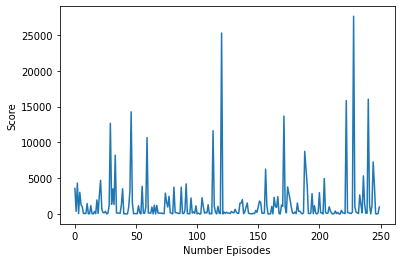

Clipped DDQN Network result:
Average score = 1153.28


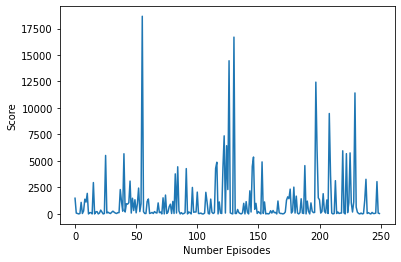

In [11]:
#Play multiple games without training and output the average score
def play_games(network, time_limit, num_games):
    scores = []
    for game in range(num_games):
        state, _ = env.reset()
        
        #For epsilon greedy policy
        #network.train = False

        for t in range(time_limit):
            action = network.act(state)
            new_state, reward, terminated, _, info = env.step(action)
            state = new_state

            if terminated == True:
                break
        scores.append(env.score)
    print(f"Average score = {sum(scores)/len(scores)}")
    return scores

print("DDQN Network result:")
ddqn_scores = play_games(ddqn_model, 30000, 250)
plt.plot(ddqn_scores)
plt.ylabel("Score")
plt.xlabel("Number Episodes")
plt.show()

print("Clipped DDQN Network result:")
cddqn_scores = play_games(cddqn_model, 30000, 250)
plt.plot(cddqn_scores)
plt.ylabel("Score")
plt.xlabel("Number Episodes")
plt.show()